In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.image as mpimg
import copy
import glob
from skimage.feature import hog
from skimage import data, exposure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from PIL import Image
from time import time
from sklearn.svm import LinearSVC
from datetime import datetime
# sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
# sys.path.append('/opt/ros/kinetic/lib/python2.7/dist-packages')

In [10]:
def readImages(path):
    image_list = []
    for filename in glob.glob(path):
        im = mpimg.imread(filename)
        image_list.append(im)
    return image_list

In [11]:
def drawBoxes(image, bboxes, color = (0,0,255), thickness = 5):
    img = copy.deepcopy(image)
    for box in bboxes:
        pt1, pt2 = box[0], box[1]
        cv2.rectangle(img, pt1, pt2,color,thickness)
    return img

In [12]:
def colorHist(image, n_bins = 32, bins_range = (0,256)):
    red_channel, green_channel, blue_channel = 0, 1, 2
    red_hist = np.histogram(image[:,:,red_channel], n_bins,bins_range)
    green_hist = np.histogram(image[:,:,green_channel], n_bins, bins_range)
    blue_hist = np.histogram(image[:,:,blue_channel], n_bins, bins_range)
    # bin centres are same for all three channels
    # compute bin centres from any one of the channels
    bin_edges = red_hist[1]
    bin_centres = (bin_edges[0: len(bin_edges)-1] + bin_edges[1:]) / 2
    hist_features = np.concatenate((red_hist[0], green_hist[0], blue_hist[0]), axis = None)
    return red_hist, green_hist, blue_hist, bin_centres, hist_features    

In [13]:
def binSpatial(image, cspace = 'RGB',size = (32,32)):
    
    img = copy.deepcopy(image)
    # do color conversion if specified
    if cspace != 'RBG':
        if cspace == 'HSV':
            img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            img = cv2.cvtColor(img,cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        elif cspace == 'YCrCb':
            img = cv2.cvtColor(img,cv2.COLOR_RGB2YCR_CB)
        elif cspace == 'YUV':
            img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
    
    # resize the image and unroll it
    img = cv2.resize(img, size)
    img = np.array(img)
    img = np.ravel(img)
    return img

In [14]:
def getHogFeatures(img, 
                   orient, 
                   pixels_per_cell, 
                   cells_per_block, 
                   vis = True, 
                   transform_sqrt = False,
                   multichannel = False):
    
    hog_features, hoge_image = hog(img, orientations = orient,
                        pixels_per_cell = (pixels_per_cell,pixels_per_cell),
                        cells_per_block = (cells_per_block,cells_per_block),
                        visualise = vis,
                        transform_sqrt = transform_sqrt,
                        multichannel = multichannel)
    if vis:
        return hog_features, hoge_image
    else:
        return hog_features


In [15]:
def extractFeatures(images, 
                    cspace = 'RGB', 
                    spatial_size = (32,32),
                    hist_bins = 32, hist_range = (0,256)):
    
    features = []
    for image_i in images:
        # generate spaial features
        fv1 = binSpatial(image_i, cspace = cspace,size = spatial_size)
        # generate histogram features
        rh, gh, bh, bincen, fv2 = colorHist(image_i)
        combined_feature = np.concatenate((fv1, fv2))
        features.append(combined_feature)
    
    features = np.vstack(features).astype(np.float64)
    return features

In [16]:
def slide_window(img, x_start_stop = [None, None], y_start_stop = [None, None], 
                    xy_window = (64, 64), xy_overlap = (0.5, 0.5)):
    
    # get the dimensions of an image
    image_dim_y , image_dim_x = img.shape[0:2]
    
    # set start and stop in x and y axes if not mentioned
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = image_dim_x
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = image_dim_y

    window_x, window_y = xy_window[0], xy_window[1]
    overlap_x = int(xy_overlap[0] * window_x)
    overlap_y = int(xy_overlap[1] * window_y)

    window_list = []
    
    j = y_start_stop[0]
    while j + window_y < image_dim_y:
        i = x_start_stop[0]
        while i + window_x < image_dim_x:
            box_start =  (i , j)
            box_end = (i + window_x , j + window_y)
            window_list.append((box_start, box_end))
            i = i + overlap_x
        j  = j + overlap_y
        
    return window_list

In [17]:
def singleImgFeatures(img, 
                      cspace = 'RGB', 
                      spatial_size = (32, 32),
                      hist_bins = 32, 
                      orient = 9, 
                      pixels_per_cell = 8, 
                      cells_per_block = 2, 
                      hog_channel = 0,
                      spatial_feat = True, 
                      hist_feat = True, 
                      hog_feat = True): 
    
    img_features = []
    if cspace != 'RBG':
        if cspace == 'HSV':
            img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            img = cv2.cvtColor(img,cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        elif cspace == 'YCrCb':
            img = cv2.cvtColor(img,cv2.COLOR_RGB2YCR_CB)
        elif cspace == 'YUV':
            img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
    
    feature_image = np.copy(img)
    if spatial_feat:
        spatial_features = binSpatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    
    if hist_feat:
        histogram_features = colorHist(feature_image, n_bins = hist_bins)[4] 
        img_features.append(histogram_features)
        
    if hog_feat:
        hog_features = []
        if hog_channel == "ALL":
            no_of_channels = feature_image.shape[2]
            for channel in range(no_of_channels):
                hog_features.extend(getHogFeatures(feature_image[:,:,channel],
                                                   orient = orient,
                                                   pixels_per_cell = pixels_per_cell, 
                                                   cells_per_block = cells_per_block))
        else:
            hog_features.append(getHogFeatures(feature_image[:,:,hog_channel],
                                                   orient = orient,
                                                   pixels_per_cell = pixels_per_cell, 
                                                   cells_per_block = cells_per_block))
        hog_features = np.ravel(hog_features)
        img_features.append(hog_features)
        
    img_features = np.concatenate(img_features)
    return img_features

In [18]:
def search_windows(img, 
                   windows, 
                   clf, 
                   scaler, 
                   cspace = 'RGB', 
                   spatial_size = (32, 32), 
                   hist_bins = 32, 
                   hist_range = (0, 256), 
                   orient = 9, 
                   pixels_per_cell = 8, 
                   cells_per_block = 2, 
                   hog_channel = 0, 
                   spatial_feat = True, 
                   hist_feat = True, 
                   hog_feat = True):

    on_windows = []

    for window in windows:
        
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))

        window_img_features = singleImgFeatures(window_img, 
                                                cspace = cspace, 
                                                spatial_size = spatial_size,
                                                hist_bins = hist_bins,
                                                orient = orient,
                                                pixels_per_cell = pixels_per_cell,    
                                                cells_per_block = 2,
                                                hog_channel = hog_channel,
                                                spatial_feat = spatial_feat,
                                                hist_feat = hist_feat,
                                                hog_feat = hog_feat)

        window_img_features = scaler.transform(np.array(window_img_features).reshape(1, -1))
        prediction = clf.predict(window_img_features)
        if prediction == 1:
            on_windows.append(window)
        
    return on_windows

In [19]:
# import car and non car images
car_images = readImages('./vehicles_smallset/vehicles_smallset/cars1/*.jpeg')
non_car_images = readImages('./non-vehicles_smallset/non-vehicles_smallset/notcars1/*.jpeg')

# extract features for car and non car images
car_features = extractFeatures(car_images)
non_car_features = extractFeatures(non_car_images)
# feature vectors for car and non car images
X = np.vstack((car_features, non_car_features))
# assign label 1 for car and 0 for non car
car_labels = np.ones((len(car_features)))
non_car_labels = np.zeros((len(non_car_features)))
# vector containing ground truth labels
y = np.hstack((car_labels,non_car_labels))

In [20]:
# shuffle and split the data into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# fit the per column scaler only on the training dataset only
X_scaler = StandardScaler().fit(X_train)
# apply scaler on training and testing dataset
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

# create an instance of linear support vector machine
vehicle_classifier = LinearSVC()
start_time = time()
# train the classifier, note the time taken for training the classifier
vehicle_classifier.fit(scaled_X_train, y_train)
elapsed_time = time() - start_time
print("training time: %.2f"% elapsed_time)

training time: 0.59


In [21]:
# make predictions on test dataset
y_pred = vehicle_classifier.predict(scaled_X_test)

# ground truth labels
y_true = y_test

# print the classification report, accuracy and confusion matrix
print("Classification report: \n", classification_report(y_true, y_pred))
model_accuracy = accuracy_score(y_true, y_pred)
print("Model accuracy in percentage:%0.2f" % model_accuracy)

#confusion matrix
c_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix: \n", c_matrix)

Classification report: 
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       128
         1.0       0.99      0.96      0.97       135

    accuracy                           0.97       263
   macro avg       0.97      0.97      0.97       263
weighted avg       0.97      0.97      0.97       263

Model accuracy in percentage:0.97
Confusion Matrix: 
 [[127   1]
 [  6 129]]


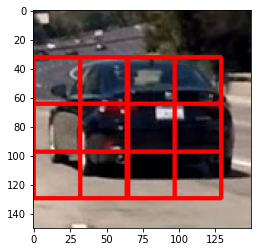

In [22]:
sample_car_image =  mpimg.imread('./test1.jpg')
windows = slide_window(sample_car_image, x_start_stop=[None, None], y_start_stop=[None, None], 
                        xy_window=(65, 65), xy_overlap=(0.5, 0.5))

windows = slide_window(sample_car_image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(65, 65), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(sample_car_image, windows, vehicle_classifier, X_scaler, hog_feat = False)  
window_img = drawBoxes(sample_car_image, hot_windows, color=(255, 0, 0), thickness=2)                    

plt.imshow(window_img)
plt.show()